# 1. Import Libraries:

In [22]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# 2. Load Dataset:

In [23]:
df = pd.read_csv("/kaggle/input/resume-vs-job-description-matching-dataset/resume_job_matching_dataset.csv")
df = df.dropna(subset=["job_description", "resume"])
df = df.reset_index(drop=True)

# 3. Exploratory Data Analysis (EDA):

In [24]:

print("Dataset size:", df.shape)
display(df.head())

Dataset size: (10000, 3)


,job_description,resume,match_score
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5


In [25]:
# Check columns and datatypes
print("\nColumn Info:")
df.info()


Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_description  10000 non-null  object
 1   resume           10000 non-null  object
 2   match_score      10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [26]:
# Summary statistics for match_score
print("\nMatch Score Statistics:")
print(df["match_score"].describe())


Match Score Statistics:
count    10000.00000
mean         3.50030
std          1.16899
min          1.00000
25%          3.00000
50%          4.00000
75%          4.00000
max          5.00000
Name: match_score, dtype: float64


In [27]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
job_description    0
resume             0
match_score        0
dtype: int64


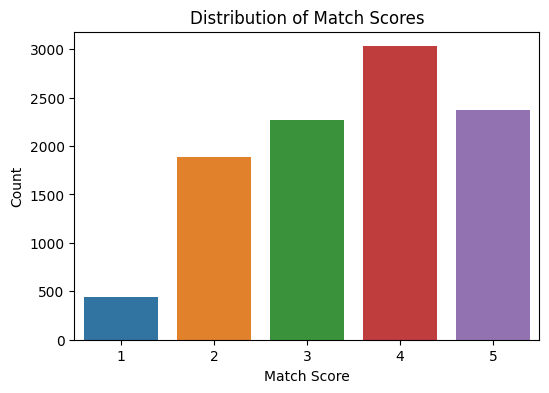

In [28]:
# Distribution of match scores
plt.figure(figsize=(6,4))
sns.countplot(x="match_score", data=df)
plt.title("Distribution of Match Scores")
plt.xlabel("Match Score")
plt.ylabel("Count")
plt.show()

- There is no missing value in the dataset 

# 4. Load Model:

In [29]:
model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 5. Encode Job Descriptions & Resumes:

In [30]:

job_embeddings = model.encode(df["job_description"].tolist(), convert_to_tensor=True)
resume_embeddings = model.encode(df["resume"].tolist(), convert_to_tensor=True)


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

# 6. Cosine Similarity per Pair:

In [31]:

similarities = cosine_similarity(job_embeddings.cpu(), resume_embeddings.cpu())


In [32]:

# similarity[i, i] is job i vs resume i
df["predicted_similarity"] = [similarities[i][i] for i in range(len(df))]


# 7. Evaluation:

In [33]:
# Using minmaxscaler() to scale match_score to [0,1]
scaler = MinMaxScaler()
df["match_score_scaled"] = scaler.fit_transform(df[["match_score"]])

mse = mean_squared_error(df["match_score_scaled"], df["predicted_similarity"])
print("\nScaled Mean Squared Error (MSE): ", mse)

print("\n")
display(df.head())


Scaled Mean Squared Error (MSE):  0.09225629752727585




,job_description,resume,match_score,predicted_similarity,match_score_scaled
0,"Data Analyst needed with experience in SQL, Ex...","Experienced professional skilled in SQL, Power...",4,0.635744,0.75
1,Data Scientist needed with experience in Stati...,"Experienced professional skilled in Python, De...",4,0.554686,0.75
2,Software Engineer needed with experience in Sy...,"Experienced professional skilled in wait, Git,...",5,0.448453,1.00
3,"ML Engineer needed with experience in Python, ...","Experienced professional skilled in return, De...",4,0.423394,0.75
4,Software Engineer needed with experience in RE...,"Experienced professional skilled in REST APIs,...",5,0.537128,1.00


# 8. Resume Scoring and Job Matching:

## Top 5 Resume Matches for the First Job in table

In [34]:
job_id = 0
job_text = df.loc[job_id, "job_description"]

# Extract title from the job description
job_title = " ".join(job_text.split()[:2])  

print(f"\nJob {job_id} Title: {job_title}")
print(f"Job {job_id} Description:\n{job_text[:50]}...\n")

# Encode this job
job_embedding = model.encode([job_text], convert_to_tensor=True)

# Compare against all resumes
cos_sims = cosine_similarity(job_embedding.cpu(), resume_embeddings.cpu()).flatten()

# Ranking DataFrame
ranking = df.copy()
ranking["similarity_score"] = cos_sims
ranking = ranking.sort_values(by="similarity_score", ascending=False)

print(f"Top 5 resumes for Job {job_id}:")
display(ranking[["resume", "similarity_score"]].head(5))



Job 0 Title: Data Analyst
Job 0 Description:
Data Analyst needed with experience in SQL, Excel,...



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Top 5 resumes for Job 0:


,resume,similarity_score
8202,"Experienced professional skilled in Reporting,...",0.756251
4779,"Experienced professional skilled in SQL, Repor...",0.731731
1507,"Experienced professional skilled in Tableau, D...",0.726615
7203,"Experienced professional skilled in SQL, Data ...",0.724541
4354,"Experienced professional skilled in SQL, Repor...",0.723967


## Bar Plot Visualition:

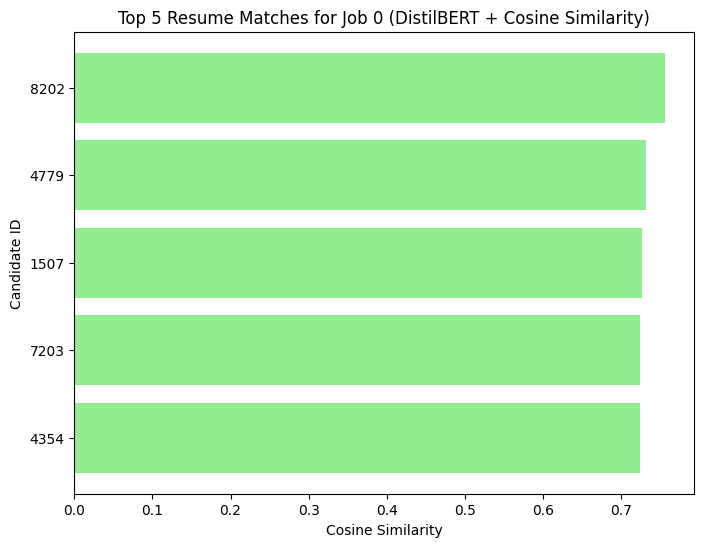

In [35]:
top5 = ranking.head(5)
plt.figure(figsize=(8,6))
plt.barh(top5.index.astype(str), top5["similarity_score"], color='lightgreen')
plt.gca().invert_yaxis()
plt.title(f"Top 5 Resume Matches for Job {job_id} (DistilBERT + Cosine Similarity)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Candidate ID")
plt.show()

## Job infos + top 5 candidates:

In [36]:
ranking["candidate_id"] = ranking.index
top5 = ranking.head(5)

print(f"\nJob {job_id} Title: {job_title}")
print(f"Job {job_id} Description:\n{job_text[:100]}...\n") 

print("Top 5 Candidates:")
for idx, row in top5.iterrows():
    print("=" * 80)
    print(f"\nCandidate ID: {row['candidate_id']}")
    print(f"Similarity Score: {row['similarity_score']:.4f}")
    print(f"Resume:\n{row['resume'][:50]}...\n")



Job 0 Title: Data Analyst
Job 0 Description:
Data Analyst needed with experience in SQL, Excel, Power BI, Reporting, Data Cleaning, Tableau. Anyt...

Top 5 Candidates:

Candidate ID: 8202
Similarity Score: 0.7563
Resume:
Experienced professional skilled in Reporting, SQL...


Candidate ID: 4779
Similarity Score: 0.7317
Resume:
Experienced professional skilled in SQL, Reporting...


Candidate ID: 1507
Similarity Score: 0.7266
Resume:
Experienced professional skilled in Tableau, Data ...


Candidate ID: 7203
Similarity Score: 0.7245
Resume:
Experienced professional skilled in SQL, Data Clea...


Candidate ID: 4354
Similarity Score: 0.7240
Resume:
Experienced professional skilled in SQL, Reporting...

